In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display, HTML as HTML_display
from pandas.plotting import autocorrelation_plot
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import tqdm

In [2]:
data = pd.read_excel('../../../data/tb_stock.xlsx')
df = data[['sc_date', 'sc_ap_stock']]
df.set_index('sc_date', inplace=True)  # Date컬럼을 index로 변환

In [3]:
df

,sc_ap_stock
sc_date,
2014-09-17,25.395000
2014-09-18,25.447500
2014-09-19,25.240000
2014-09-20,25.240000
2014-09-21,25.240000
...,...
2024-08-29,229.789993
2024-08-30,229.000000
2024-08-31,229.000000


In [ ]:
# 파라미터 옵션 설정

# 트렌드(추세) 요소(trend): 데이터가 장기적인 측면에서 증가하거나 감소하는 모양새를 의미.
# 순환 요소(cycle): 불규칙적이며 반복적인 장기적인 변화 현상을 의미. 급격한 변화가 없다면 지속되는 특징
# 계절 요소(seasonal): 주, 월, 분기, 반기, 1년 등 특정 주기로 반복되는 특징을 의미
# 불규칙 요소(random/residual): 일정한 규칙성을 인지할 수 없는 변동의 유형. 추세, 순환, 계절성을 뺀 나머지

# 'add(덧셈)'옵션: 추세, 순환, 계절, 불규칙의 합. Trend와 Seasonal이 별개
# 'mul(곱셈)'옵션: 추세, 순환, 계절, 불규칙의 곱. 시간이 지남에 따라(Trend가 상승함에 따라) 변동폭이 증가
# 'Damping'옵션, 시간의 경과에 따라 **추세(trend)**가 점차 감소하거나 완화되는 효과.
#  댐핑된 추세는 시간이 지나면서 추세의 기울기가 감소하여 평평해지는 형태를 취함. 추세 성분에 댐핑 계수를 곱하여 점진적으로 그 영향력을 감소
#  이는 현실적으로 많은 경제, 금융, 그리고 자연 현상에서 장기적으로 무한한 성장이나 감소는 없다고 가정할 때 유용

In [4]:
# 기간 설정
sort_df = df.loc['2024-03-01' : '2024-08-31']

# 훈련, 테스트 데이터 나누기
train_size = int(len(sort_df) * 0.70)
train = sort_df['sc_ap_stock'][:train_size]
test = sort_df['sc_ap_stock'][train_size:]

param_grid = {
    'trend': [None, 'add', 'mul'],                           # 트렌드(추세) 옵션: 없음, 덧셈적, 곱셈적. 
    'seasonal': [None, 'add', 'mul'],                        # 계절성 옵션: 없음, 덧셈적, 곱셈적
    'seasonal_periods': [None, 1, 7, 15, 30, 90, 180, 365],  # 계절성 주기: 없음, 일 주, 달, 분기, 반기, 년 등..
    'damped_trend': [True, False],                           # 댐핑된 트렌드 사용 여부
}

# 하이퍼파라미터 초기화
best_score = float('inf')
best_params = None
best_model = None

# 그리드 서치 수행
for params in ParameterGrid(param_grid):  # ParameterGrid를 통한 파라미터 조합 생성
    try:
        # 모델 생성 및 학습
        model = ExponentialSmoothing(
            train,
            trend=params['trend'],
            seasonal=params['seasonal'],
            seasonal_periods=params['seasonal_periods'],
            damped_trend=params['damped_trend']
        ).fit()

        # 예측
        predictions = model.forecast(len(test))
        
        # 평가지표
        mse = mean_squared_error(test, predictions)
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        r2 = r2_score(test, predictions)
        
        # MSE 값 기준으로 최적모델 저장
        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = model
            best_metrics = {
                'MSE': mse,
                'MAE': mae,
                'MAPE': mape,
                'R²': r2
            }

    except Exception as e:
        print(f"Error with parameters {params}: {e}")

c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

Error with parameters {'damped_trend': True, 'seasonal': None, 'seasonal_periods': None, 'trend': None}: Can only dampen the trend component
Error with parameters {'damped_trend': True, 'seasonal': None, 'seasonal_periods': 1, 'trend': None}: Can only dampen the trend component
Error with parameters {'damped_trend': True, 'seasonal': None, 'seasonal_periods': 7, 'trend': None}: Can only dampen the trend component
Error with parameters {'damped_trend': True, 'seasonal': None, 'seasonal_periods': 15, 'trend': None}: Can only dampen the trend component


c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

Error with parameters {'damped_trend': True, 'seasonal': None, 'seasonal_periods': 30, 'trend': None}: Can only dampen the trend component
Error with parameters {'damped_trend': True, 'seasonal': None, 'seasonal_periods': 90, 'trend': None}: Can only dampen the trend component
Error with parameters {'damped_trend': True, 'seasonal': None, 'seasonal_periods': 180, 'trend': None}: Can only dampen the trend component
Error with parameters {'damped_trend': True, 'seasonal': None, 'seasonal_periods': 365, 'trend': None}: Can only dampen the trend component


c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': None, 'trend': None}: Can only dampen the trend component


c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 1, 'trend': None}: Can only dampen the trend component
Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 1, 'trend': 'add'}: seasonal_periods must be larger than 1.
Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 1, 'trend': 'mul'}: seasonal_periods must be larger than 1.
Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 7, 'trend': None}: Can only dampen the trend component


c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 15, 'trend': None}: Can only dampen the trend component


c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 30, 'trend': None}: Can only dampen the trend component


c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 90, 'trend': None}: Can only dampen the trend component
Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 90, 'trend': 'add'}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 90, 'trend': 'mul'}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 180, 'trend': None}: Can only dampen the trend component
Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 180, 'trend': 'add'}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': True, 'seasonal': 'add', 'seasonal_pe

c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  sel

Error with parameters {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 1, 'trend': None}: Can only dampen the trend component
Error with parameters {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 1, 'trend': 'add'}: seasonal_periods must be larger than 1.
Error with parameters {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 1, 'trend': 'mul'}: seasonal_periods must be larger than 1.
Error with parameters {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 7, 'trend': None}: Can only dampen the trend component


c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Error with parameters {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 15, 'trend': None}: Can only dampen the trend component


c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Error with parameters {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 30, 'trend': None}: Can only dampen the trend component


c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

Error with parameters {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 90, 'trend': None}: Can only dampen the trend component
Error with parameters {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 90, 'trend': 'add'}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 90, 'trend': 'mul'}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 180, 'trend': None}: Can only dampen the trend component
Error with parameters {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 180, 'trend': 'add'}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': True, 'seasonal': 'mul', 'seasonal_pe

c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

Error with parameters {'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 1, 'trend': None}: seasonal_periods must be larger than 1.
Error with parameters {'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 1, 'trend': 'add'}: seasonal_periods must be larger than 1.
Error with parameters {'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 1, 'trend': 'mul'}: seasonal_periods must be larger than 1.


c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  sel

Error with parameters {'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 90, 'trend': None}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 90, 'trend': 'add'}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 90, 'trend': 'mul'}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 180, 'trend': None}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 180, 'trend': 'add'}: Cannot compute initial seasonals u

c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

Error with parameters {'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 1, 'trend': None}: seasonal_periods must be larger than 1.
Error with parameters {'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 1, 'trend': 'add'}: seasonal_periods must be larger than 1.
Error with parameters {'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 1, 'trend': 'mul'}: seasonal_periods must be larger than 1.


c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  sel

Error with parameters {'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 90, 'trend': None}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 90, 'trend': 'add'}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 90, 'trend': 'mul'}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 180, 'trend': None}: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error with parameters {'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 180, 'trend': 'add'}: Cannot compute initial seasonals u

c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\4\anaconda3\envs\projectM4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

In [5]:
# 결과 출력
print("학습일:", len(train))
print("예측일:", len(test))
print("Best Parameters:", best_params)
print("Best MSE:", best_score)
print("Best Metrics:", best_metrics)

학습일: 128
예측일: 56
Best Parameters: {'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': None, 'trend': None}
Best MSE: 44.92266702954897
Best Metrics: {'MSE': 44.92266702954897, 'MAE': 4.9514924609925846, 'MAPE': 0.02260656680742936, 'R²': -0.2321472533533433}


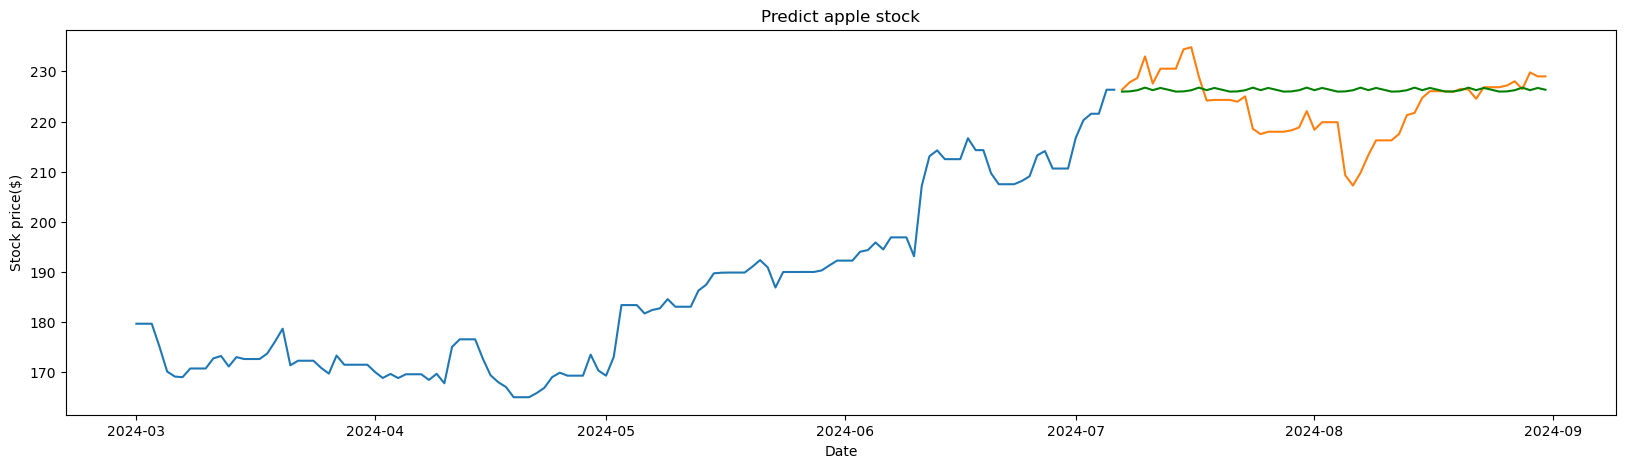

In [6]:
# 최적 모델 예측 시각화

# 인덱스 데이터타입을 date로 변경
train.index = pd.to_datetime(train.index)
test.index =  pd.to_datetime(test.index)

# 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, best_model.forecast(len(test)), label='Forecast', color='g')

# 그래프 제목 및 레이블 설정
plt.title('Predict apple stock')
plt.xlabel('Date')
plt.ylabel('Stock price($)')

plt.show()

In [8]:
# # 모델 저장
# with open('Regression_Apple_ExponentialSmoothing.pkl', 'wb') as file:
#     pickle.dump(model, file)

# 모델 불러오기
model = pickle.load(open('Regression_Apple_ExponentialSmoothing.pkl', 'rb'))

In [10]:
def predict_stock(stock, date):
    predict_date = datetime.strptime(date, '%Y-%m-%d')
    train_last_date = datetime.strptime(f'{train.index[-1].year}-{train.index[-1].month}-{train.index[-1].day}', '%Y-%m-%d')
    date_sub = predict_date - train_last_date
    predictions = model.forecast(date_sub.days)
    return f'{stock} {date}: {predictions[-1]}'

predict_stock('apple', '2024-09-19')

C:\Users\4\AppData\Local\Temp\ipykernel_13476\1889801973.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return f'{stock} {date}: {predictions[-1]}'


'apple 2024-09-19: 303.8936434672898'

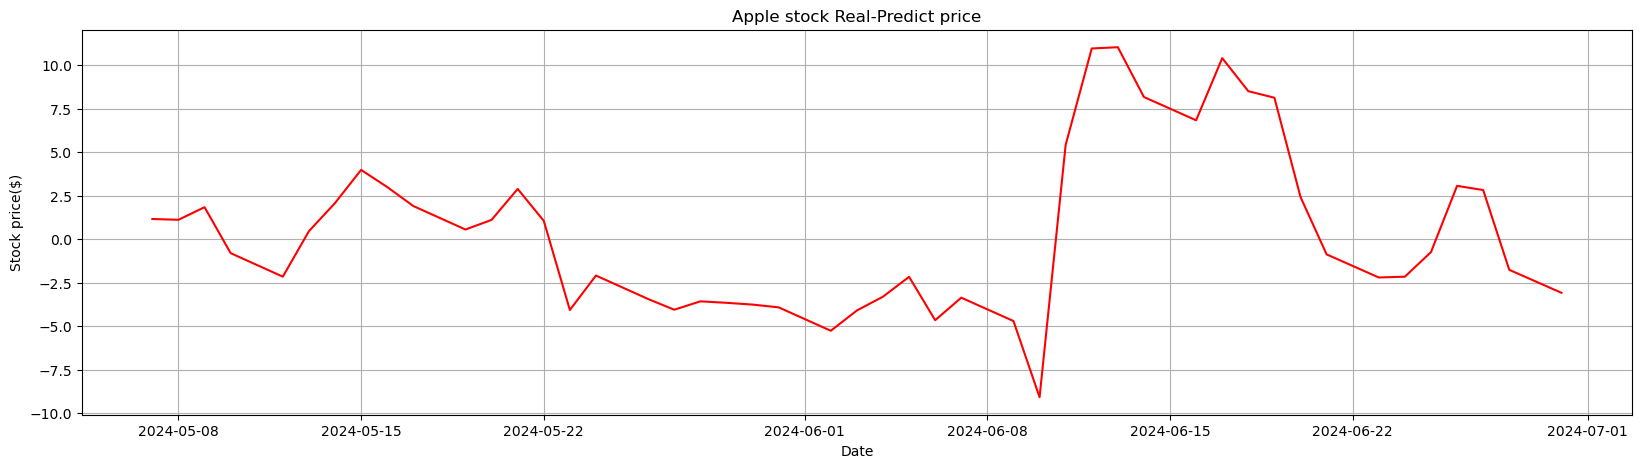

In [11]:
# 차분 그래프

# 잔차 계산
predict_df = pd.DataFrame(best_model.forecast(len(test)), index=test.index, columns=['apple_predict'])
test_df = pd.DataFrame(test, index=test.index, columns=['sc_ap_stock'] )
predict_df = test_df.join(predict_df)
predict_df['sub'] = predict_df['sc_ap_stock'] - predict_df['apple_predict']

# 인덱스 데이터타입을 date로 변경
predict_df.index =  pd.to_datetime(test.index)

# 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(predict_df.index, predict_df['sub'], color='red')

# 그래프 제목 및 레이블 설정
plt.title('Apple stock Real-Predict price')
plt.xlabel('Date')
plt.ylabel('Stock price($)')

plt.grid(True)
plt.show()

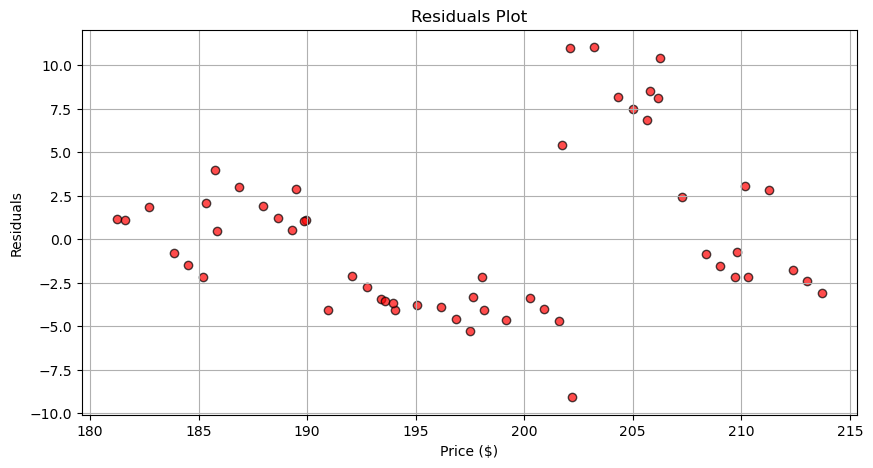

In [12]:
# 잔차 플롯

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.scatter(predict_df['apple_predict'], predict_df['sub'], color='r', edgecolor='k', alpha=0.7)

plt.title('Residuals Plot')
plt.xlabel('Price ($)')
plt.ylabel('Residuals')

plt.grid(True)
plt.show()

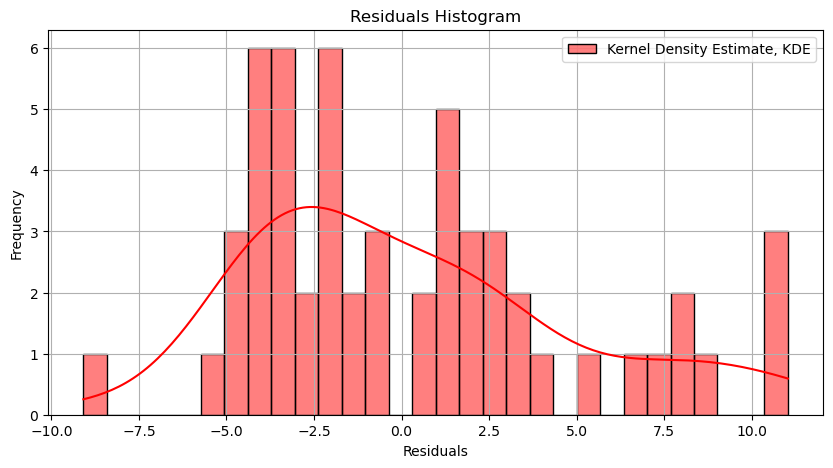

In [13]:
# 잔차 히스토그램
# 커널 밀도 추정 그래프 커브가 정규 분포와 유사한 모양을 가지면 잔차가 정규 분포를 따를 가능성이 있음
plt.figure(figsize=(10, 5))
sns.histplot(predict_df['sub'], kde=True, color='r', bins=30, label='Kernel Density Estimate, KDE')  # 커널밀도추정(Kernel Density Estimate, KDE) 곡선을 추가

plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()

plt.grid(True)
plt.show()

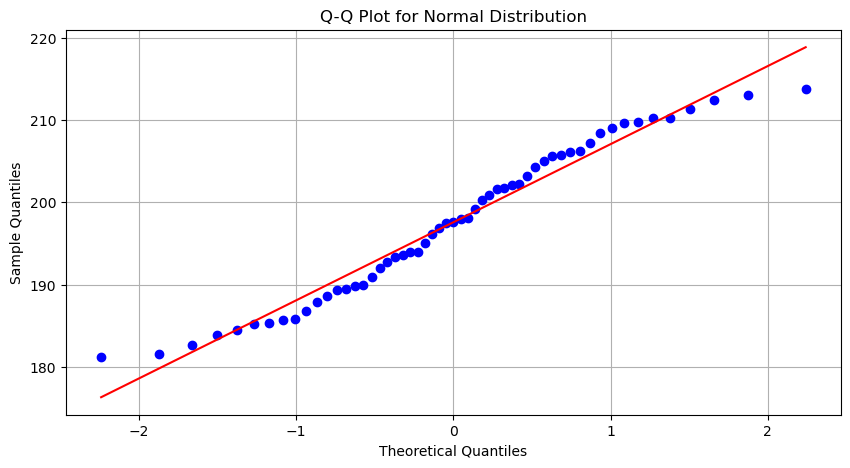

In [14]:
# Q-Q 플롯 생성
# 잔차가 정규 분포를 따르는 경우 Q-Q 플롯의 점들이 대각선에 가까워 짐

plt.figure(figsize=(10, 5))
stats.probplot(predict_df['apple_predict'], dist="norm", plot=plt)

plt.title('Q-Q Plot for Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.grid(True)
plt.show()

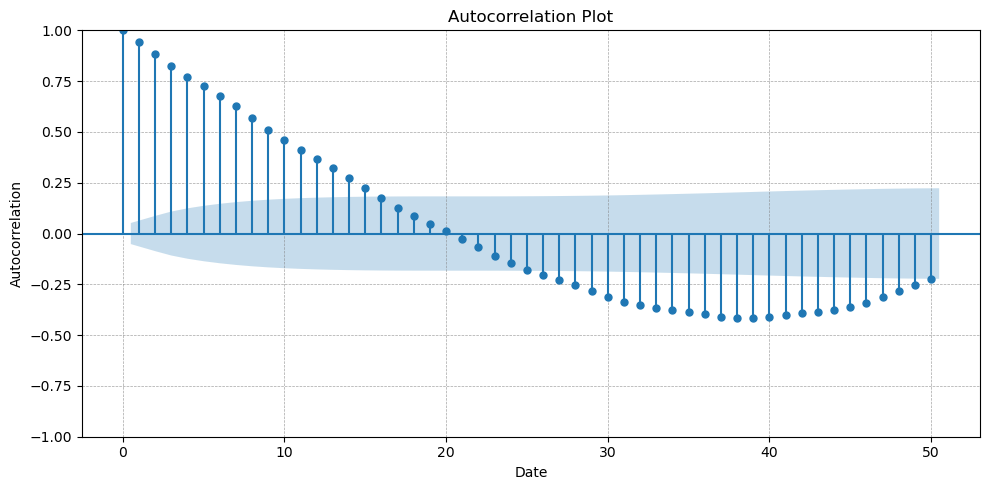

In [15]:
# 자기 상관도 그래프 - 시계열 데이터의 자기상관(자기상관관계)을 시각적으로 표현

# 그래프 그리기
plt.figure(figsize=(10, 5))
plot_acf(predict_df['apple_predict'], lags=50, ax=plt.gca(), alpha=0.7)  # lags는 최대 지연 시간
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

plt.title('Autocorrelation Plot')
plt.xlabel('Date')
plt.ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

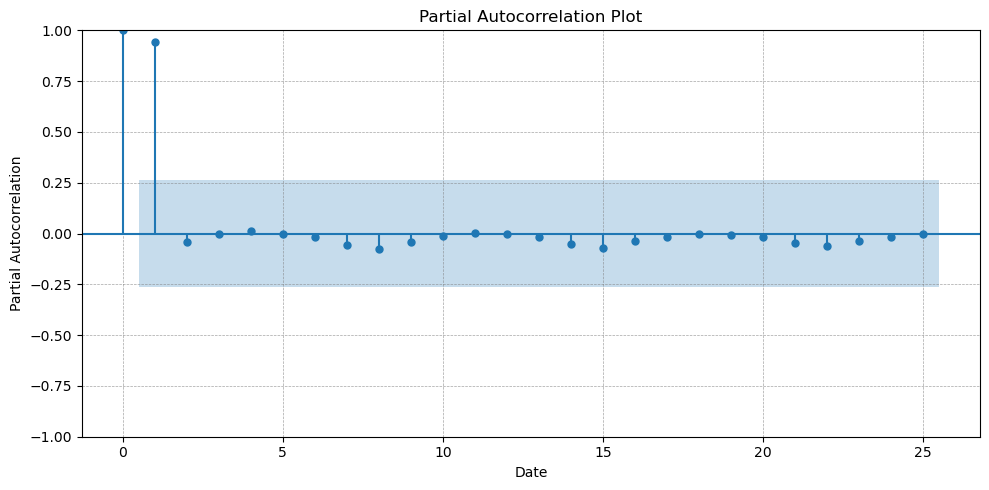

In [16]:
# 부분 자기 상관 그래프

# 그래프 그리기
plt.figure(figsize=(10, 5))
plot_pacf(predict_df['apple_predict'], lags=25, ax=plt.gca())
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

plt.title('Partial Autocorrelation Plot')
plt.xlabel('Date')
plt.ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

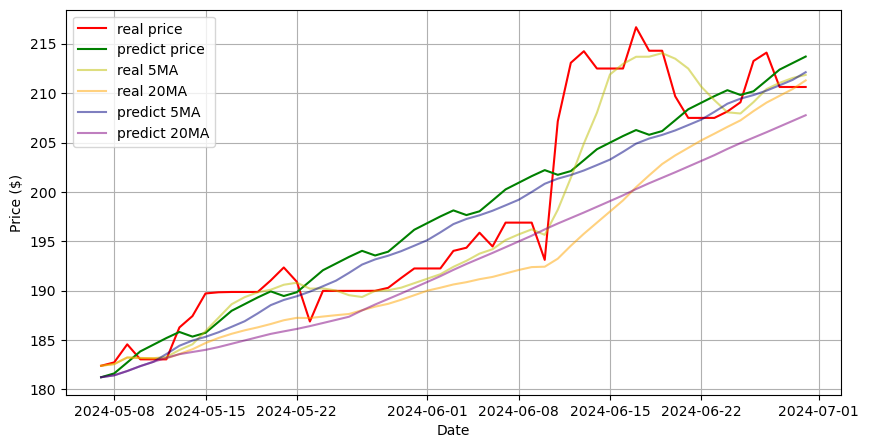

In [17]:
# 이동 평균 그래프 (Moving Average Plot)

# 이동 평균 구하기
predict_df['real5MA'] = predict_df['sc_ap_stock'].rolling(window=5, min_periods=0).mean()         # 5일 이동평균
predict_df['real20MA'] = predict_df['sc_ap_stock'].rolling(window=20, min_periods=0).mean()       # 20일 이동평균
predict_df['predict5MA'] = predict_df['apple_predict'].rolling(window=5, min_periods=0).mean()    # 5일 이동평균
predict_df['predict20MA'] = predict_df['apple_predict'].rolling(window=20, min_periods=0).mean()  # 20일 이동평균

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(predict_df.index, predict_df['sc_ap_stock'], color='r', label='real price')
plt.plot(predict_df.index, predict_df['apple_predict'], color='g', label='predict price')
plt.plot(predict_df.index, predict_df['real5MA'], color='y', label='real 5MA', alpha=0.5)
plt.plot(predict_df.index, predict_df['real20MA'], color='orange', label='real 20MA', alpha=0.5)
plt.plot(predict_df.index, predict_df['predict5MA'], color='navy', label='predict 5MA', alpha=0.5)
plt.plot(predict_df.index, predict_df['predict20MA'], color='purple', label='predict 20MA', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

plt.show()

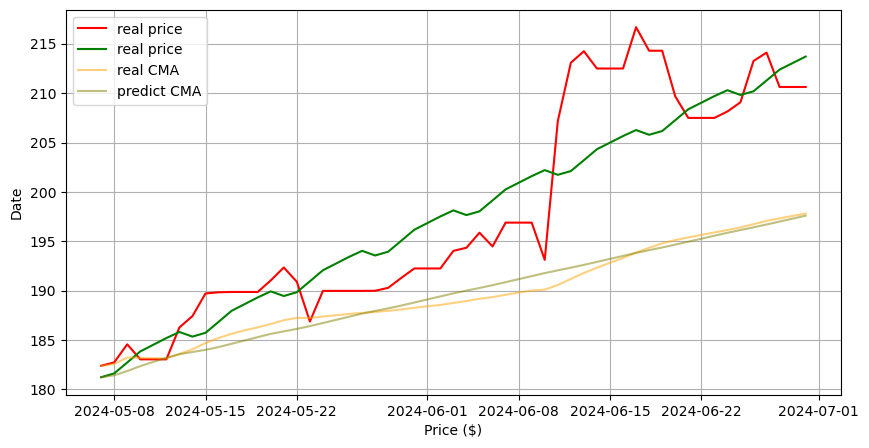

In [18]:
# 누적 이동 평균 그래프 (Cumulative Moving Average Plot)

# 누적 이동 평균 구하기
predict_df['realCMA'] = predict_df['sc_ap_stock'].expanding().mean()
predict_df['predictCMA'] = predict_df['apple_predict'].expanding().mean()

# # 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(predict_df.index, predict_df['sc_ap_stock'], color='r', label='real price')
plt.plot(predict_df.index, predict_df['apple_predict'], color='g', label='real price')
plt.plot(predict_df.index, predict_df['realCMA'], color='orange', label='real CMA', alpha=0.5)
plt.plot(predict_df.index, predict_df['predictCMA'], color='olive', label='predict CMA', alpha=0.5)

plt.xlabel('Price ($)')
plt.ylabel('Date')
plt.legend()
plt.grid()

plt.show()

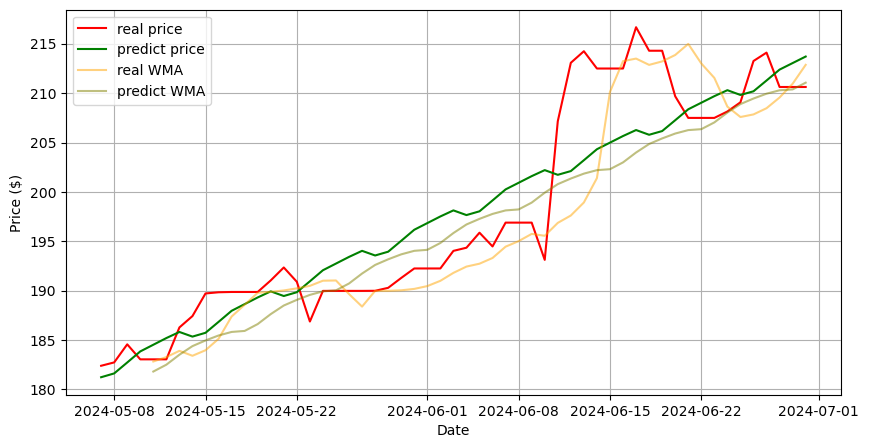

In [23]:
# 가중 이동 평균 그래프

# 가중 이동 평균 구하기
w = np.array((2, 1, 0.5, 0.3, 0.1))
predict_df['realWMA'] = predict_df['sc_ap_stock'].rolling(5).apply(lambda x: np.dot(x, w)/w.sum(), raw=True)
predict_df['predictWMA'] = predict_df['apple_predict'].rolling(5).apply(lambda x: np.dot(x, w)/w.sum(), raw=True)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(predict_df.index, predict_df['sc_ap_stock'], color='r', label='real price')
plt.plot(predict_df.index, predict_df['apple_predict'], color='g', label='predict price')
plt.plot(predict_df.index, predict_df['realWMA'], color='orange', label='real WMA', alpha=0.5)
plt.plot(predict_df.index, predict_df['predictWMA'], color='olive', label='predict WMA', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.show()